# Analysis of Commercial Real Estate (CRE) Market Index

## Executive Summary

The goal of this analysis was to identify trends in multi-family commercial real estate across regions in the United States. The predictive power of variables were tested and correlations observed.


## The Data

The Atlanta Federal Reserve calculates and publishes the Commercial Real Estate Market Index (CREMI), a quarterly indicator that tracks overall commercial real estate conditions across roughly 390 U.S. metro areas and their surrounding regions. The index provides a broad indication of commercial real estate market conditions that can serve as a basis for further analysis.

The Atlanta Fed also publishes a diffusion index that highlights the share of commercial real estate and economic measures exhibiting positive momentum.

The data the Atlanta Federal Reserve uses to create the CREMI are obtained through public and nonpublic data sources. Among the underlying economic factors are occupancy rates, market cap rates, asset values, unemployment rates, and more.


<table border="1" cellspacing="0" cellpadding="2" width="100%">
  <thead>
    <tr>
      <th colspan="4"><strong>Asset Type: Multifamily</strong></th>
    </tr>
    <tr>
      <th>Variable</th>
      <th>Type</th>
      <th>Transformation</th>
      <th><center>Sign</center></th>
    </tr>
  </thead>

  <tbody>
    <tr>
      <td>Occupancy Rate</td>
      <td>CRE*</td>
      <td>Level</td>
      <td><center>+</center></td>
    </tr>
    <tr>
      <td>Net Operating Income Index</td>
      <td>CRE</td>
      <td>Log Change (YoY)</td>
      <td><center>+</center></td>
    </tr>
    <tr>
      <td>Market Cap Rate</td>
      <td>CRE</td>
      <td>Level</td>
      <td><center>-</center></td>
    </tr>
    <tr>
      <td>Asset Value</td>
      <td>CRE</td>
      <td>Percent Change (YoY)</td>
      <td><center>+</center></td>
    </tr>
    <tr>
      <td>Absorption Units</td>
      <td>CRE</td>
      <td>Levels</td>
      <td><center>+</center></td>
    </tr>
    <tr>
      <td>Unemployment Rate</td>
      <td>Economic</td>
      <td>Level</td>
      <td><center>-</center></td>
    </tr>
    <tr>
      <td>Households</td>
      <td>Economic</td>
      <td>Percent Change (YoY)</td>
      <td><center>+</center></td>
    </tr>
    <tr>
      <td>Industrial Production</td>
      <td>Economic</td>
      <td>Percent Change (YoY)</td>
      <td><center>+</center></td>
    </tr>
    <tr>
      <td>CPI</td>
      <td>Economic</td>
      <td>Percent Change (YoY)</td>
      <td><center>-</center></td>
    </tr>
  </tbody>
  <tfoot>
    <tr>
      <td colspan="4" style="font-size:0.8rem; margin: 0.5rem 0; padding: 4px;">
        *Economic factors for variables with type "CRE" in the table above are proprietary and not publicly available.
      </td>
    </tr>
  </tfoot>
</table>


### Obtain the Data

The data was obtained from the [Atlanta Fed website](https://www.atlantafed.org/research/data-and-tools/commercial-real-estate-market-index?utm_source=chatgpt.com#Tab7).
The data included a CSV file titled CREMI_CBSA_Results.csv with 1,741,070 rows and 7 columns and a size of 157 MB.


In [45]:
import duckdb

con = duckdb.connect()

raw = con.read_csv("datasets/CREMI_CBSA_Results.csv").df()
# con.register("df", df)
print(f"{raw.shape[0]:,} rows and {raw.shape[1]:,} columns")


1,741,070 rows and 7 columns


### Preview the Data

The raw data includes the region (Geography.Name), a regional code (CBSA.Code), the asset type (Asset_Type), date (DT), variable name (variable), and values for each variable.


In [46]:
raw.head(5)

,column0,Geography.Name,CBSA.Code,Asset_Type,DT,variable,value
0,1,Abilene - TX,10180,Office,20071231,CREMI,0.700718
1,2,Abilene - TX,10180,Office,20080331,CREMI,0.432477
2,3,Abilene - TX,10180,Office,20080630,CREMI,0.146078
3,4,Abilene - TX,10180,Office,20080930,CREMI,-0.466332
4,5,Abilene - TX,10180,Office,20081231,CREMI,-2.466985


### Data Cleaning

The original dataset was reformatted to facilitate analysis and modeling. Column names were standardized, and unnecessary columns were removed. Missing and duplicate values were identified and addressed, and data types were converted as needed to ensure consistency and usability. Moreover, unnecessary data columns were removed from the data set.

### Rename Columns

First, the column titles were renamed for readability.


In [47]:
import pandas as pd

# Create a copy of the raw data
df = raw.copy() 

# Reformat column names
df.columns = [c.replace(".", "_") for c in df.columns]
df.rename(columns={'DT': 'Date', 'variable': 'Variable', 'value': 'Value'}, inplace=True)

### Date Type Conversion

The date variable was converted to a date type to standardize it an prepare it for time series analysis.


In [48]:

# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df['Date'] = df['Date'].dt.date


### Remove Unnecessary Data

Next, unnecessary columns were removed. The original data set contained a Geography_Name representing the city and state of the region as well as a CBSA_Code. The Geography_Name and CBSA_Code variables describe the same geographical unit so the CBSA_Code was dropped from the table. For further confirmation of this, the presence of a 1-to-1 matching of the Geography_Name and CBSA_Code was tested and confirmed below.


In [49]:

# Drop unnecessary columns
df.drop('column0', axis=1, inplace=True)

# Does every Geography_Name have exactly one CBSA_Code and vice versa?
if (df.groupby("Geography_Name")["CBSA_Code"].nunique() == 1).all() and(df.groupby("CBSA_Code")["Geography_Name"].nunique() == 1).all():
    print("True. Every Geography_Name has exactly one CBSA_Code and vice versa. It's safe to drop the CBSA_Code column.")
    # Drop the CBSA_Code column
    df.drop("CBSA_Code", axis=1, inplace=True)
else: 
    print("False. There is not a 1-to-1 mapping between Geography_Name and CBSA_Code.")
    

True. Every Geography_Name has exactly one CBSA_Code and vice versa. It's safe to drop the CBSA_Code column.


### Missing Data

The data appears to contain no missing values.


In [52]:
# Find missing values
df.isna().sum()

Geography_Name    0
Asset_Type        0
Date              0
Variable          0
Value             0
dtype: int64

### Filter the Data

This analysis focused on the CREMI variable, so all variables except the CREMI variable were filtered out.


In [ ]:
cremi = df[df['Variable'] == 'CREMI'].copy()
cremi.drop("Variable", axis=1, inplace=True)
cremi.rename(columns={"Value": "CREMI"}, inplace=True)

(174107, 4)

### Cleaned Data Set

The final cleaned data set can be seen below. This data will be used in further analysis.


In [61]:
cremi.head()

,Geography_Name,Asset_Type,Date,CREMI
0,Abilene - TX,Office,2007-12-31,0.700718
1,Abilene - TX,Office,2008-03-31,0.432477
2,Abilene - TX,Office,2008-06-30,0.146078
3,Abilene - TX,Office,2008-09-30,-0.466332
4,Abilene - TX,Office,2008-12-31,-2.466985


## Exploratory Data Analysis

The next step was to Next, we determined that there are five unique asset types. Each one contained over 30,000 CREMI values.


In [62]:
# Show unique asset types
print(cremi["Asset_Type"].value_counts().map("{:,}".format))


Asset_Type
Multifamily    40,490
Hospitality    37,440
Office         32,473
Industrial     32,467
Retail         31,237
Name: count, dtype: object


Moreover, there are 390 unique geographic regions represented in the data.


In [64]:
# Show unique geographic regions
print(f"{len(cremi["Geography_Name"].unique())} unique regions")


390 unique regions


Each geographic region and asset type had a time series with start and end dates. Start dates for CREMI values began at various dates with many beginning in the early 2000s The end date was the most recent quarter end, March 31, 2025.


In [65]:
cremi['Start_Date'] = cremi.groupby(['Geography_Name', 'Asset_Type'])['Date'].transform('min')
cremi['End_Date'] = cremi.groupby(['Geography_Name', 'Asset_Type'])['Date'].transform('max')

cremi[['Geography_Name', 'Asset_Type', 'Start_Date', 'End_Date']].drop_duplicates().reset_index(drop=True)

,Geography_Name,Asset_Type,Start_Date,End_Date
0,Abilene - TX,Office,2007-12-31,2025-03-31
1,Akron - OH,Office,2000-03-31,2025-03-31
2,Albany - GA,Office,2007-12-31,2025-03-31
3,Albany - NY,Office,2007-09-30,2025-03-31
4,Albany - OR,Office,2003-03-31,2025-03-31
...,...,...,...,...
1945,Yakima - WA,Hospitality,2001-06-30,2025-03-31
1946,York - PA,Hospitality,2001-06-30,2025-03-31
1947,Youngstown - OH,Hospitality,2001-06-30,2025-03-31
1948,Yuba City - CA,Hospitality,2001-06-30,2025-03-31


## Exploratory Data Analysis

The CREMI index value is provided for multiple regional areas within each state. We looked at the CREMI average index value per state.


C:\Users\aaron\AppData\Local\Temp\ipykernel_20888\2178806418.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(5, 'CREMI'))


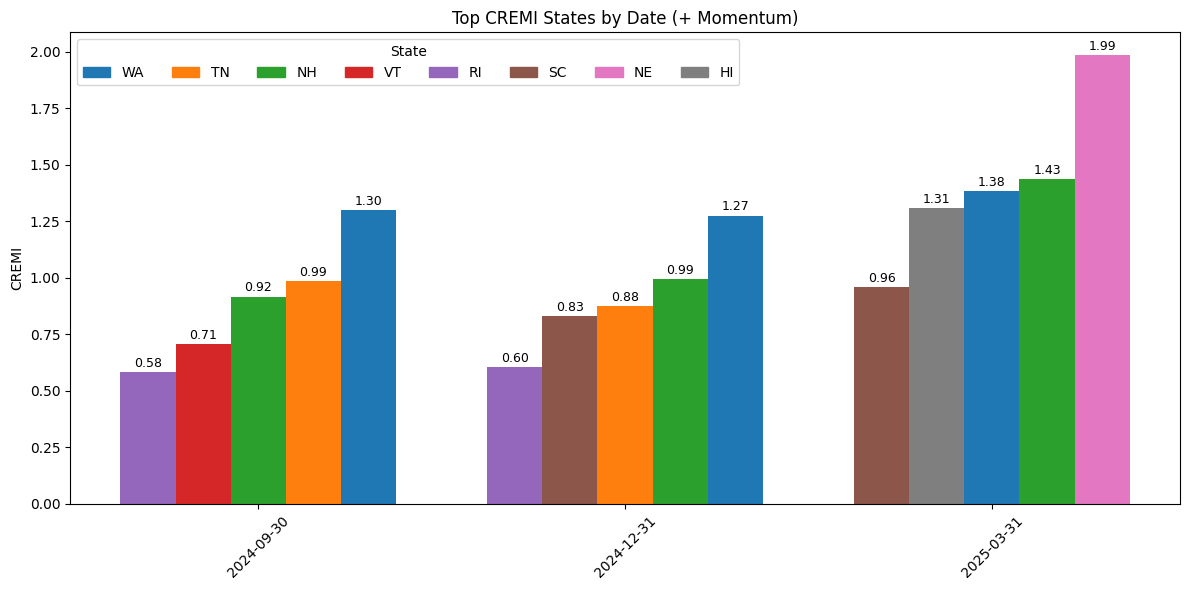

In [137]:
import pandas as pd
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


mf = cremi[cremi['Asset_Type'] == 'Multifamily'].copy().drop("Asset_Type", axis=1) # Extract the State 
mf['State'] = mf['Geography_Name'].str.split(' - ').str[1] 
mf['State'].nunique() 
by_state = mf.groupby(['State', 'Date']).agg({'CREMI': 'mean'}).reset_index()

by_state['CREMI_MA(1Y)'] = by_state.groupby('State')['CREMI'].rolling(window=4, min_periods=4).mean().reset_index(level=0, drop=True)

# Get values for most recent date 
# by_state = by_state.sort_values('Date').groupby('State').tail(4)
by_state = by_state[by_state['Date'] >= date(2024, 9, 30)]


# Step 1: Flag positive momentum
by_state['+ Momentum'] = (by_state['CREMI'] > by_state['CREMI_MA(1Y)']) & (by_state['CREMI'] > 0)

# Step 2: Keep only rows with positive momentum
positive = by_state[by_state['+ Momentum']].copy()

# Only keep top 5 states per date (or filter as needed)
top5 = (
    positive.groupby('Date')
    .apply(lambda x: x.nlargest(5, 'CREMI'))
    .reset_index(drop=True)
)



# Plot using seaborn
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

# Unique states and assign colors
states = top5['State'].unique()
cmap = plt.get_cmap("tab10")
colors = [cmap(i) for i in range(cmap.N)]  # cmap.N = 10
state_to_color = {state: colors[i % len(colors)] for i, state in enumerate(states)}

# Unique dates
dates = sorted(top5['Date'].unique())

# Bar width
width = 0.15
fig, ax = plt.subplots(figsize=(12,6))

# Plot bars
for i, d in enumerate(dates):
    date_data = top5[top5['Date'] == d].sort_values('CREMI')  # Sort ascending

    n = len(date_data)
    x = i + np.arange(n) * width  # positions for bars in this group
    for j, row in enumerate(date_data.itertuples()):
        ax.bar(x[j], row.CREMI, width=width, color=state_to_color[row.State])
        ax.text(x[j], row.CREMI + 0.01, f"{row.CREMI:.2f}", ha='center', va='bottom', fontsize=9)

# X-ticks in the center of each group
group_centers = [i + (len(top5[top5['Date']==d])-1)*width/2 for i, d in enumerate(dates)]
# Add value label above the bar

ax.set_xticks(group_centers)
ax.set_xticklabels(dates, rotation=45)
ax.set_ylabel("CREMI")
ax.set_title("Top CREMI States by Date (+ Momentum)")

# Create legend with correct colors
handles = [Rectangle((0,0),1,1, color=state_to_color[state]) for state in states]
ax.legend(handles, states, title="State", loc='upper left', ncol=len(states))

plt.tight_layout()
plt.show()





# # Step 3: Rank states by CREMI for each date (highest CREMI = rank 1)
# positive['Rank'] = positive.groupby('Date')['CREMI'].rank(method='first', ascending=False)

# # Step 4: Keep top 5 states per date
# top5 = positive[positive['Rank'] <= 5]

# print(top5.sort_values(["Date"]))
# # Step 5: Pivot so each state is a column
# pivoted = top5.pivot(index='Date', columns='State', values='CREMI')



# subset = by_state[
#     (by_state['Date'] > date(2024, 1, 1)) &
#     (by_state['State'].isin(['AZ', 'CA', 'TN']))
# ]

# # print(subset.columns.tolist())


In [18]:
out = con.execute(
    """
    SELECT Geography_Name, Asset_Type, Date, Value 
    FROM df 
    WHERE Asset_Type = 'Multifamily'
    """).fetchdf()
print(out)

       Geography_Name   Asset_Type       Date     Value
0        Abilene - TX  Multifamily 2000-03-31  0.924655
1        Abilene - TX  Multifamily 2000-06-30  1.079491
2        Abilene - TX  Multifamily 2000-09-30  1.114240
3        Abilene - TX  Multifamily 2000-12-31  1.372490
4        Abilene - TX  Multifamily 2001-03-31  1.680532
...               ...          ...        ...       ...
404895      Yuma - AZ  Multifamily 2024-03-31 -0.056288
404896      Yuma - AZ  Multifamily 2024-06-30 -0.045621
404897      Yuma - AZ  Multifamily 2024-09-30 -0.015903
404898      Yuma - AZ  Multifamily 2024-12-31 -0.005362
404899      Yuma - AZ  Multifamily 2025-03-31 -0.001177

[404900 rows x 4 columns]
